# INM430 : Tiny DS Project Progress Report


***

** Student Name: **  Binh T. Vu

** Project Title:** Credit Fraud Detection

***





## Part-1: Data source and domain description (maximum 150 words):



E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is
moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing
money laundry, et .
Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit
card information has a risk team in charge of avoiding frauds via machine learning.

The goal of this report is to build a machine learning model that predicts the probability that the first
transaction of a new user is fraudulent.

### Data Information

We have included a zip file called “Fraud.zip” that contains two tables:

- Fraud Data: Information about each user first transaction
 - Columns of fraud adta:
   - User_id: Id of user., unique by user
   - signup_time: the time when the user created her account
   - purchase_time: the time when the user bought the item
   - purchase_value: the cost of the purchased item (USD)
   - device_id: the device it. You can assume that it is unique by device. I.e., 2 transactions wih the same device ID menas that the same physical device was used to buy
   - source: user marketing channel: ads, SEO, Direct (i.e cam tot he site by directly typing the site address on the browser).
   - browser: the browser used by the user.
   - ip_address: user numeric ip address
   - class: this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).
   
   
- IpAddress_to_Country: mapping each numeric ip address to its country. For each country, it gives a range. If the numeric ip address falls within the range, then the ip address belongs to the corresponding country.
 - Columns of the IpAddress_to_Country:
   - lower_bound_ip_address: the lower bound of the numeric ip address for that country
   - upper_bound_ip_address: the upper bound of the numeric ip address for that country
   - country: the corressponding country. If a user has an ip address whose value is within the upper and lower bound, the she is based in this country.
   

Link: https://drive.google.com/file/d/1a04XKxiMfPCKfX5eSsCpWwxBwSC3dYYn/view?usp=sharing

## Part-2: Analysis Strategy and Plans (maximum 200 words):

The task is to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. The datasets provide  only have information about the user first transaction on the site and based on that you have to make your classification (“fraud/no fraud”).

There are 2 datasets which are fraud data and the IP address of these users. 

Thus, there are two tasks that need to do: 

- For each user, determine her country based on the numeric IP address.

- Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.



## Part-3: Initial investigations on the data sources (maximum 150 words): 

The most important features in spotting fraud were determined to be:

- The speed that customers moved from sign up to proceed the transactions
- Whether or not multiple user id's were being generated from a single device or ip address

During the data exploration, it is noted  that not all ip addresses in the dataset can be tracked to a country of origin. Regardless, country of origin does not play a significant role in determining fraudsters so it doesn't really matter.

I built three models:

- Logistic Regression: 
- Random forest
- LightGBM

# 1. Data Preparation

In [1]:
# import the required package
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob, re
import seaborn as sns
from datetime import datetime,date
np.random.seed(99)
import warnings
warnings.filterwarnings("ignore")

### Read in and clean the data


In [2]:
# Read in fraud data
Fraud_Data = pd.read_csv("Fraud_Data.csv", header=0)

# Read in ISP data
IpAddress_to_Country = pd.read_csv("IpAddress_to_Country.csv", header=0)

## Fraud data

First, check format of columns in fraud datset.

In [3]:
for col in Fraud_Data.columns:
    print ("{}: {}".format(col, Fraud_Data[col].dtype))

user_id: int64
signup_time: object
purchase_time: object
purchase_value: int64
device_id: object
source: object
browser: object
sex: object
age: int64
ip_address: float64
class: int64


In [4]:
# Check for nulls
print ("Check for null values")
for col in Fraud_Data.columns:
    print ("# of null values in {}: {}".format(col, Fraud_Data[col].isnull().sum()))


Check for null values
# of null values in user_id: 0
# of null values in signup_time: 0
# of null values in purchase_time: 0
# of null values in purchase_value: 0
# of null values in device_id: 0
# of null values in source: 0
# of null values in browser: 0
# of null values in sex: 0
# of null values in age: 0
# of null values in ip_address: 0
# of null values in class: 0


There is no missing values in this dataset.

In [5]:
Fraud_Data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


### ISP data
First, check format of columns in ISP dataset.

In [6]:
ISP_df = pd.read_csv("IpAddress_to_Country.csv", header=0)

In [7]:
for col in ISP_df.columns:
    print ("{}: {}".format(col, ISP_df[col].dtype))

lower_bound_ip_address: float64
upper_bound_ip_address: int64
country: object


In [8]:
# Check for nulls
print ("Check for null values")
for col in ISP_df.columns:
    print ("# of null values in {}: {}".format(col, ISP_df[col].isnull().sum()))

Check for null values
# of null values in lower_bound_ip_address: 0
# of null values in upper_bound_ip_address: 0
# of null values in country: 0


## Mapping IP address

Perform mapping country names from the IP address

In [9]:
def ip_to_country(ip):
    tmp_ser = ISP_df[ (ISP_df.lower_bound_ip_address <= ip) 
                    & (ISP_df.upper_bound_ip_address >= ip) ].country
    if tmp_ser.shape[0] == 1:
        return tmp_ser.iloc[0]
    elif tmp_ser.shape[0] < 1:
        return "Missing"
    elif tmp_ser.shape[0] > 1:
        return "Error"
    
Fraud_Data["country"] = Fraud_Data.ip_address.apply(ip_to_country)

In [10]:
# See again data after mapping IP address
Fraud_Data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Missing
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [11]:
# factorize attributes : 'sex', 'country', 'source', 'browser' for visualization purpose
data = Fraud_Data.copy()
for variable in ['country','sex','source','browser']:
    data[variable] = data[variable].factorize()[0]

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,0,0,0,39,7.327584e+08,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,1,0,1,53,3.503114e+08,0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,0,1,0,53,2.621474e+09,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,0,2,0,41,3.840542e+09,0,2
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,1,2,0,45,4.155831e+08,0,1


# 2.  Basic visualizations

Here I display some basic visualizations to aid in understanding the dataset. First, I'll explore the correlation between sex and class. Males make up more of the customer base of the company and thus are also involved in more of the fraud cases. It doesn't look like one gender is more likely to participate in fraud though, just that one gender tends to use the site more in general.

Text(0, 0.5, 'Counts')

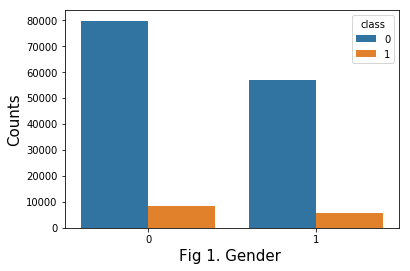

In [12]:
sns.countplot(x='sex', hue='class', data=data)
plt.xlabel("Fig 1. Gender ", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Next, the visualization of class distribution

Class 0: 136961
Class 1: 14151
Proportion: 9.68 : 1


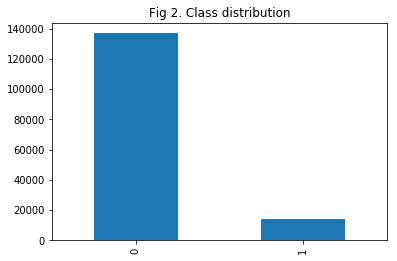

In [13]:
target_count = data['class'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Fig 2. Class distribution');

This dataset presents imbalanced of data as the majority of transactions is not fraudulent with less than 10% of fraudulent transaction.

Next, I explore the relationship between purchase value and fraud. Although there is a slight increase in the average purchase value associated with fraudulent activity, the errors bars are far too high to spot a real trend.

Text(0.42499999999999716, 0.5, 'Purchase Value')

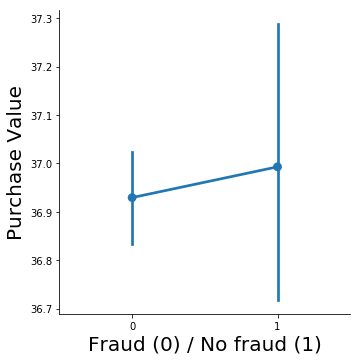

In [14]:
sns.factorplot(x="class", y="purchase_value", data=data, title='Fig 3. Purchase value vs fraud')
plt.xlabel("Fraud (0) / No fraud (1)", fontsize=20)
plt.ylabel("Purchase Value", fontsize=20)

Next, I explore the relationship between marketing source and fraud. It doesn't look like any given marketing source is more associated with fraud either. Although there are less direct sources associated with fraud, there are less direct sources overall and so the decrease likely has more to do with just not being as successful as search engine optimization and ads in bringing customers to the site.

Text(0, 0.5, 'Counts')

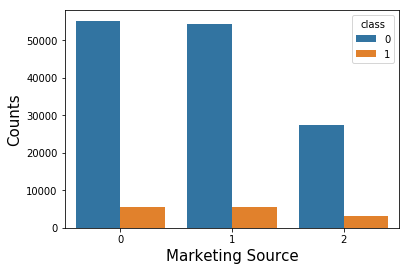

In [21]:
sns.countplot(x='source', hue='class', data=data)
plt.xlabel("Marketing Source", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Next, I explore the relationship between browser used and fraud. Again, the browser counts seem to be more indicative of their relative overall popularity rather than any meaningful trend associated with fraud.

Text(0, 0.5, 'Counts')

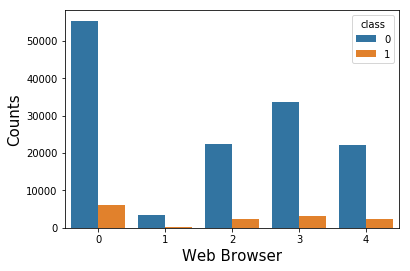

In [22]:
sns.countplot(x='browser', hue='class', data=data)
plt.xlabel("Web Browser", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Next, I explore the relationship between the number of unique user ids assocated with either a single device or a single ip address. These are clearly important correlations. It seems that multiple user ids associated with either a unique device id or ip address is a large indicator of fraudulent behaviour.

Text(16.299999999999997, 0.5, 'User ids per IP Address')

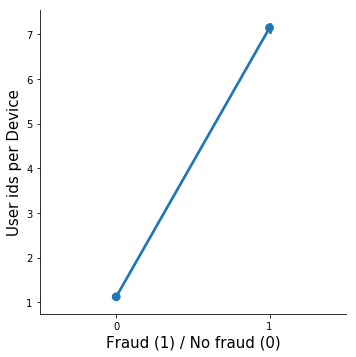

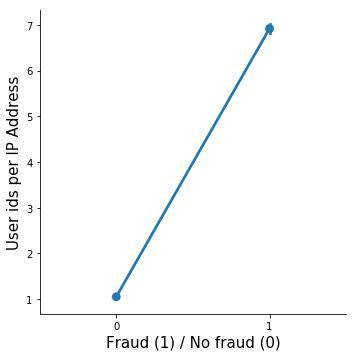

In [15]:
# Initialize a new dataframe
tmp_df = pd.DataFrame(columns=("class", "userids_per_deviceid", "userids_per_ipaddress"))
tmp_df["class"] = data["class"]

# Count the number of unique user ids associated each device
userid_count = data.groupby("device_id").user_id.count()
tmp_df["userids_per_deviceid"] = data.device_id.apply(lambda x: userid_count[x])

# Count the number of unique user ids associated each ip address
userid_count = data.groupby("ip_address").user_id.count()
tmp_df["userids_per_ipaddress"] = data.ip_address.apply(lambda x: userid_count[x])

sns.factorplot(x="class", y="userids_per_deviceid", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per Device", fontsize=15)

sns.factorplot(x="class", y="userids_per_ipaddress", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per IP Address", fontsize=15)

Next, visualise the timing difference between sign up time and purchase time

In [19]:
# Convert sign-up time and purchase time to datetime objects
tmp_df["signup_time"] = data.signup_time.apply(pd.to_datetime)
tmp_df["purchase_time"] = data.purchase_time.apply(pd.to_datetime)

Text(-8.825000000000003, 0.5, 'Sign-up to Purchase Time (Seconds)')

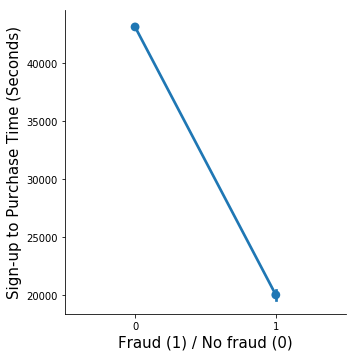

In [20]:
# Add columns for the number of seconds between purchase and sign-up times
tmp_df["signup_to_purchase_seconds"] = (tmp_df.purchase_time - tmp_df.signup_time).apply(lambda x: x.seconds)

sns.factorplot(x="class", y="signup_to_purchase_seconds", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Sign-up to Purchase Time (Seconds)", fontsize=15)

Next, I explore the relationship between time (hour of the day, day of the week, week of the year) and fraud. It looks like fraud occurs pretty regularly throughout the hours of the day and days of the week. However, it looks like a big burst of fraud occurs within the first three weeks of the year.

Text(0, 0.5, 'Count')

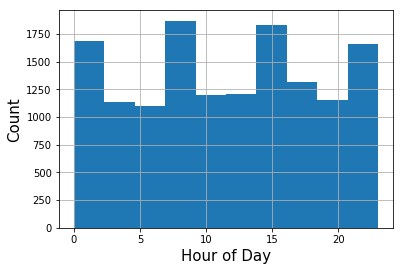

In [21]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.hour).hist()
plt.xlabel("Hour of Day", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

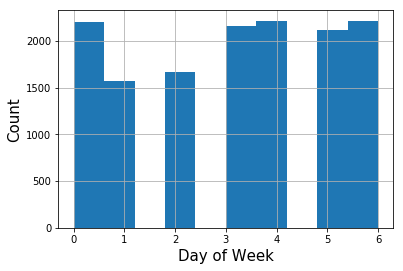

In [22]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Day of Week", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

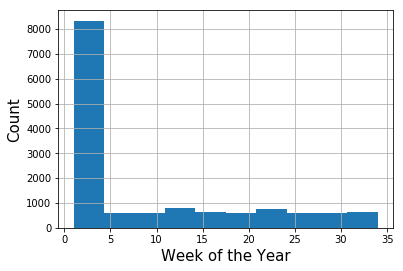

In [23]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.week).hist()
plt.xlabel("Week of the Year", fontsize=15)
plt.ylabel("Count", fontsize=15)

Finally, I explore the relationship between the time between sign-up and purchase and fraud. These are also very clearly important correlations. Extremely small time periods between sign-up and purchase are also strongly correlated with fraud.

Text(-8.825000000000003, 0.5, 'Sign-up to Purchase Time (Seconds)')

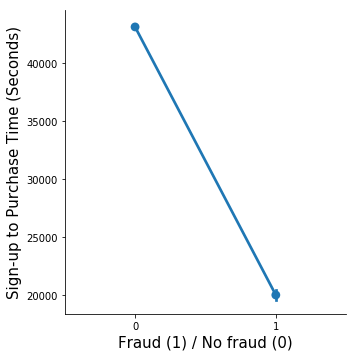

In [24]:
# Convert sign-up time and purchase time to datetime objects
tmp_df["signup_time"] = data.signup_time.apply(pd.to_datetime)
tmp_df["purchase_time"] = data.purchase_time.apply(pd.to_datetime)

# Add columns for the number of seconds between purchase and sign-up times
tmp_df["signup_to_purchase_seconds"] = (tmp_df.purchase_time - tmp_df.signup_time).apply(lambda x: x.seconds)

sns.factorplot(x="class", y="signup_to_purchase_seconds", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Sign-up to Purchase Time (Seconds)", fontsize=15)



## 3.  Feature engineering

Here, I'll list all the new features that I'll add in this section.

- Time between sign-up and first purchase in seconds

- Multiple user ids for a unique device or ip address
  - Both are equally good indicators.
  - They're highly correlated. In order to avoid any multi-colinearity, I'll generate only one feature which will be the average of the number of user ids associated with either the device id or the ip address.
  



In [15]:
# Check time between sign-up and first purchase in seconds
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['difference'] = data['purchase_time'] - data['signup_time'] 
data['difference'] = data['difference'].astype('timedelta64[m]')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,difference
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,0,0,0,39,7.327584e+08,0,0,75111.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,1,0,1,53,3.503114e+08,0,1,299.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,0,1,0,53,2.621474e+09,1,1,0.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,0,2,0,41,3.840542e+09,0,2,8201.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,1,2,0,45,4.155831e+08,0,1,72691.0


In [16]:
# extract time of purchase
data['signup_hour'] = data['signup_time'].dt.hour
data['purchase_hour']= data['purchase_time'].dt.hour
# Get day of week
data['purchase_dayofweek'] = data['purchase_time'].dt.hour

In [17]:
# Multiple user ids for a unique device or ip address
temp = data.merge(right = data[['user_id','device_id']].groupby('device_id').count().reset_index().rename(columns={'user_id':'usage_count'}),how='left',on='device_id')
data['usage_count'] = temp['usage_count']

In [18]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,difference,signup_hour,purchase_hour,purchase_dayofweek,usage_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,0,0,0,39,7.327584e+08,0,0,75111.0,22,2,2,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,1,0,1,53,3.503114e+08,0,1,299.0,20,1,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,0,1,0,53,2.621474e+09,1,1,0.0,18,18,18,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,0,2,0,41,3.840542e+09,0,2,8201.0,21,13,13,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,1,2,0,45,4.155831e+08,0,1,72691.0,7,18,18,1


# 4. Modelling.

There are two ways to approach anomaly detection from a modeling perspective, supervised and unsupervised. I'll begin with the supervised approach where I employ Logistic Regression, Random Forest, LigthGBM and Gradient Boosting



### Data preparation

In [19]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,difference,signup_hour,purchase_hour,purchase_dayofweek,usage_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,0,0,0,39,7.327584e+08,0,0,75111.0,22,2,2,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,1,0,1,53,3.503114e+08,0,1,299.0,20,1,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,0,1,0,53,2.621474e+09,1,1,0.0,18,18,18,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,0,2,0,41,3.840542e+09,0,2,8201.0,21,13,13,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,1,2,0,45,4.155831e+08,0,1,72691.0,7,18,18,1


In [21]:
X = data.drop(['class','ip_address','signup_time','purchase_time','device_id','user_id'],axis=1)
y = data['class']

In [22]:
X.head()

,purchase_value,source,browser,sex,age,country,difference,signup_hour,purchase_hour,purchase_dayofweek,usage_count
0,34,0,0,0,39,0,75111.0,22,2,2,1
1,16,1,0,1,53,1,299.0,20,1,1,1
2,15,0,1,0,53,1,0.0,18,18,18,12
3,44,0,2,0,41,2,8201.0,21,13,13,1
4,39,1,2,0,45,1,72691.0,7,18,18,1


## 4.1. Logistic regression (LR)

Logistic Regression (LR) is a type of classification algorithm involving a linear discriminant. Unlike actual regression, logistic regression does not try to predict the value of a numeric variable given a set of inputs. Instead, the output is a probability that the given input point to predict the probability of transaction is fraudulent belongs to a certain class.

In [23]:
# Prepare data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [24]:
X_train.head()

,purchase_value,source,browser,sex,age,country,difference,signup_hour,purchase_hour,purchase_dayofweek,usage_count
110752,23,1,4,0,27,5,24369.0,21,19,19,2
9211,56,2,0,0,29,2,138767.0,17,2,2,1
21458,43,1,2,0,49,2,67618.0,6,5,5,1
54851,27,2,0,0,18,4,0.0,22,22,22,10
55884,55,2,4,0,26,1,15649.0,14,10,10,1


In [25]:
# Import sklearn Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### 4.1a. Logistic regression without oversampling (SMOTE)

In [26]:
# Fit the model
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
# # prediction on test set
pred_test = clf.predict(X_test)
accuracy_score(y_test,pred_test)

0.9474572345564636

So our predictions are 94.7 % accurate, i.e. we have identified 94.7% of class of the transaction.

In [28]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

In [29]:
# # prediction on test set
pred_test_grid = log_reg.predict(X_test)
accuracy_score(y_test,pred_test_grid)

0.9517916818317176

### Confusion matrix

An interesting way to evaluate the results is by means of a confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that all class 1 entries were erroneously predicted as class 0.

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
predictions = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
score = clf.score(X_test, y_test)

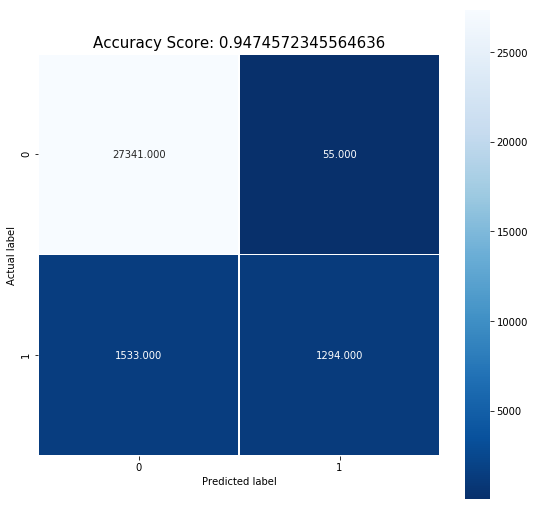

In [39]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

Even the model has 94.7% accurary rate, the  recall rate rate is less than 50% (1294/(1294+1533) which means the fraud transaction has been identified 1294 cases by LR (45.7%).



In [139]:
from sklearn.metrics import classification_report
#Print the classification report
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27396
           1       0.96      0.46      0.62      2827

   micro avg       0.95      0.95      0.95     30223
   macro avg       0.95      0.73      0.80     30223
weighted avg       0.95      0.95      0.94     30223



### ROC

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishin transaction with fraud and no fraud.

The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

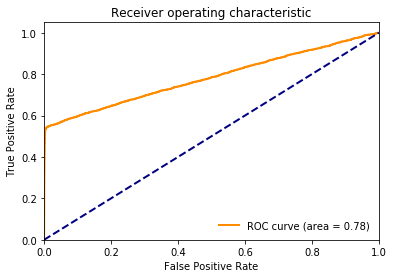

In [40]:
from sklearn.metrics import roc_curve, auc

y_pred = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right",frameon=False)

plt.show()

AUC is 0.78, it means there is 78% chance that model will be able to distinguish between fraud class and non-fraud class.

### 4.1b. Logistic regression with SMOTE

In [41]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 0.5)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [42]:
X_train_res.shape

(164347, 11)

In [43]:
# Fit the model
clf_res = LogisticRegression()
model = clf_res.fit(X_train_res, y_train_res)

In [44]:
# prediction on test set
pred_test_res = model.predict(X_test)
accuracy_score(y_test,pred_test_res)

0.95486880852331

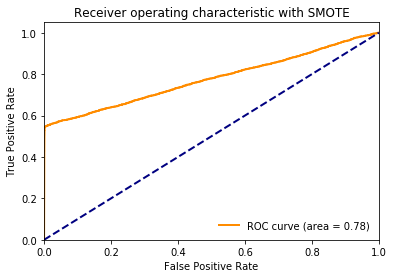

In [45]:
# Plot ROC
from sklearn.metrics import roc_curve, auc

y_pred_res = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_res[:,1])
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with SMOTE')
plt.legend(loc="lower right",frameon=False)

plt.show()

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
predictions_res = model.predict(X_test)
cm_res = metrics.confusion_matrix(y_test, predictions_res)
score_res = model.score(X_test, y_test)

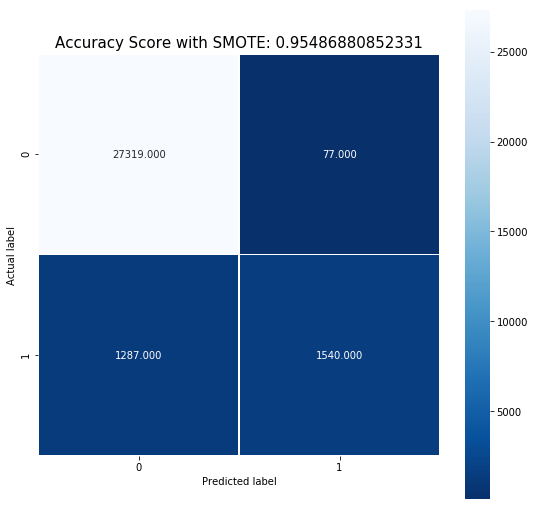

In [47]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_res, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score with SMOTE: {0}'.format(score_res)
plt.title(all_sample_title, size = 15);

With SMOTE, model does not improve the accuracy but it provides higher accurate rate of predicting fraudulent transaction (55%)

### 4. 2 Random Forest

- RandomForest is a tree based bootstrapping algorithm wherein a certain no. of weak learners (decision trees) are combined to make a powerful prediction model.
- For every individual learner, a random sample of rows and a few randomly chosen variables are used to build a decision tree model.
- Final prediction can be a function of all the predictions made by the individual learners.
- In case of regression problem, the final prediction can be mean of all the predictions.

In [59]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rfc=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(X_train,y_train)

y_pred=rfc.predict(X_test)

In [60]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9568871389339245


In [61]:
import pandas as pd
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

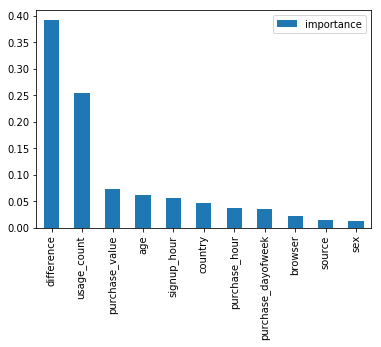

In [62]:
# Plot the importance features
feature_importances.plot.bar()

The graph shows the most important predictor is time difference which means transactions id have high probability of committing fraud if they have low timing difference between signing up and purchase.

### K-Fold Cross Validation:

K-Fold Cross Validation randomly splits the training data into K subsets called folds. Let's image we would split our data into 10 folds (K = 10). Our random forest model would be trained and evaluated 10 times, using a different fold for evaluation everytime, while it would be trained on the remaining 9 folds, the mean accuracy rate is around 95%.

In [63]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores_cv = cross_val_score(rf, X_train, y_train, cv=10, scoring = "accuracy")

In [64]:
print("Scores:", scores_cv)
print("Mean:", scores_cv.mean())
print("Standard Deviation:", scores_cv.std())

Scores: [0.95525227 0.954756   0.95632754 0.95616212 0.95731657 0.95607214
 0.9568994  0.95756122 0.95598941 0.95524487]
Mean: 0.9561581542651132
Standard Deviation: 0.0008686365634341402


### ROC

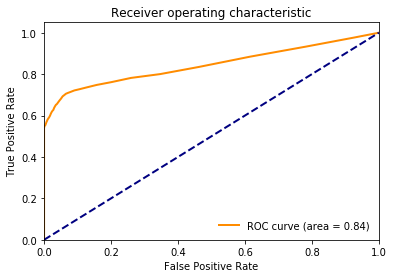

In [65]:
from sklearn.metrics import roc_curve, auc

y_pred_rfc = rfc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rfc[:,1])
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right",frameon=False)

plt.show()

### Confusion matrix

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
predictions_rfc = rfc.predict(X_test)
cm_rfc = metrics.confusion_matrix(y_test, predictions_rfc)
score_rfc = rfc.score(X_test, y_test)

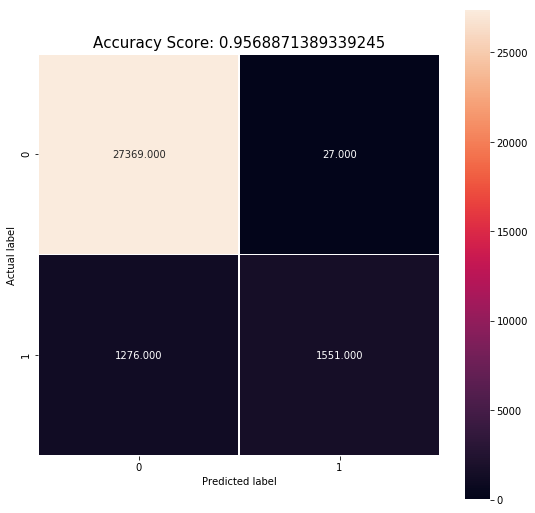

In [101]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_rfc, annot=True, fmt=".3f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_rfc)
plt.title(all_sample_title, size = 15);

In [102]:
from sklearn.metrics import classification_report
#Print the classification report
print(classification_report(y_test,predictions_rfc))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     27396
           1       0.98      0.55      0.70      2827

   micro avg       0.96      0.96      0.96     30223
   macro avg       0.97      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



 #### Let interpret the results of RF model
 
Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. For our model, we have got 0.956 which means our model is approx. 95.6% accurate.

Accuracy = TP+TN/TP+FP+FN+TN

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all transactions that labeled as not fraudulent, how many actually not fraudulent? High precision relates to the low false positive rate. We have got 0.96 precision which is quite good.

Precision = TP/TP+FP

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the transactions that is fraudulent, how many did we label? We have got recall of 0.55 which is quite good for this model as it’s above 0.5.

Recall = TP/TP+FN

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.95.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

### 3 LightBGM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.


#### Model building and training:

We need to convert our training data into LightGBM dataset format (this is mandatory for LightGBM training).

After creating a converting dataset, I created a python dictionary with parameters and their values. Accuracy of your model totally depends on the values you provide to parameters.

In the end block of parameters, I simply trained model with 50 iterations.

In [74]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)

lgb_test = lgb.Dataset(X_test,y_test)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    #'num_leaves': 8,
    'learning_rate': 0.1,
    'verbose': 50
}
print('Start training...')
# train
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_test,
                evals_result=evals_result,
                early_stopping_rounds=1)

Start training...
[1]	valid_0's binary_logloss: 0.259105
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's binary_logloss: 0.238659
[3]	valid_0's binary_logloss: 0.224538
[4]	valid_0's binary_logloss: 0.213861
[5]	valid_0's binary_logloss: 0.205368
[6]	valid_0's binary_logloss: 0.198451
[7]	valid_0's binary_logloss: 0.192747
[8]	valid_0's binary_logloss: 0.187912
[9]	valid_0's binary_logloss: 0.183856
[10]	valid_0's binary_logloss: 0.180399
[11]	valid_0's binary_logloss: 0.177427
[12]	valid_0's binary_logloss: 0.174888
[13]	valid_0's binary_logloss: 0.17268
[14]	valid_0's binary_logloss: 0.170785
[15]	valid_0's binary_logloss: 0.169165
[16]	valid_0's binary_logloss: 0.167724
[17]	valid_0's binary_logloss: 0.166491
[18]	valid_0's binary_logloss: 0.165414
[19]	valid_0's binary_logloss: 0.164457
[20]	valid_0's binary_logloss: 0.16362
[21]	valid_0's binary_logloss: 0.162855
[22]	valid_0's binary_logloss: 0.162212
[23]	valid_0's binary_logloss: 0.161645
[24]	valid_0

#### Few things to notice in parameters:

- Used ‘binary’ as objective(remember this is classification problem)
- Used ‘binary_logloss’ as metric(same reason, binary classification problem)
- ‘num_leaves’=8 (as it is small data)
- ‘boosting type’ is gbdt, we are implementing gradient boosting(you can try random forest)

### Model prediction:


Output will be a list of probabilities. I converted probabilities to binary prediction keeping threshold=0.5

In [89]:
#Prediction
y_predict = gbm.predict(X_test)
y_predict = np.where(y_predict >= 0.5, 1, 0) # setthreshold to 0.5

In [90]:
y_predict

array([0, 0, 1, ..., 1, 0, 0])

### LightGBM result :

In [95]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm_gbm = confusion_matrix(y_test, y_predict)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_predict,y_test)
accuracy

0.9573834496906329

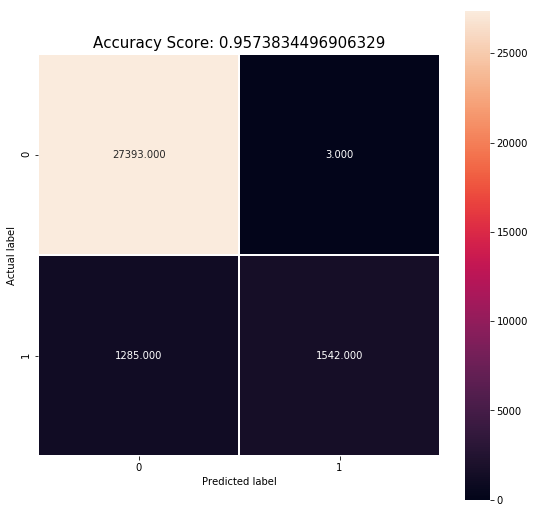

In [94]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_gbm, annot=True, fmt=".3f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [103]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     27396
           1       1.00      0.55      0.71      2827

   micro avg       0.96      0.96      0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



### Plot ROC

[0.03108798 0.02936303 0.99470428 0.02930712 0.0299411  0.02778098
 0.03090408 0.02390788 0.03345647 0.02744785]


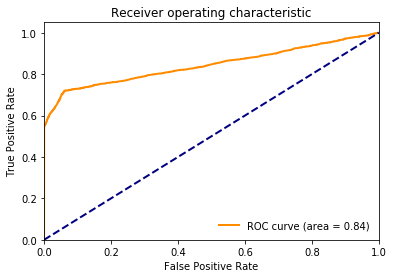

In [77]:
y_pred_gbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print(y_pred_gbm[:10])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gbm)
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right",frameon=False)

plt.show()

### Visualise important features

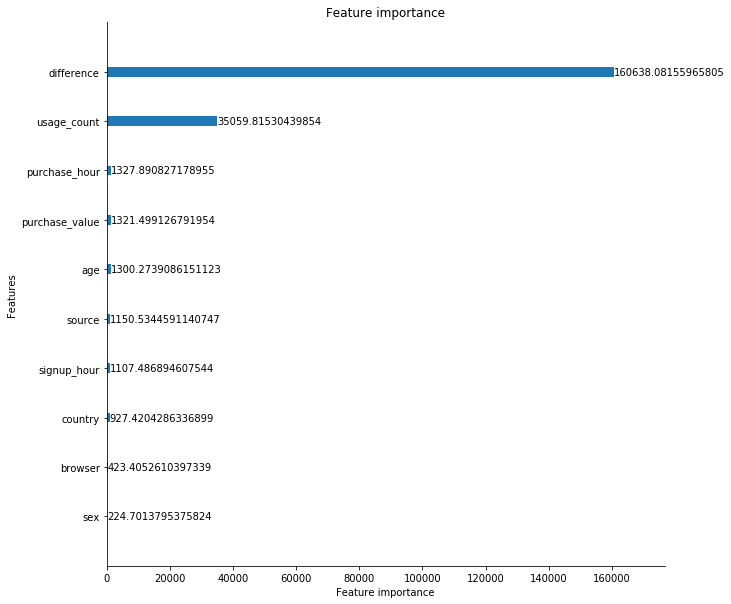

In [78]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
lgb.plot_importance(gbm,ax=ax,importance_type='gain')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

LigthBGM has also found out that the most important feature is timing differene.